In [1]:
import numpy as np
import os, datetime
from glob import glob
import re

from torch import nn
import torch

import torch.distributions as tfd
from tqdm import tqdm
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device('cuda')

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import gc
from scipy.stats import norm

import h5py, corner
from scipy.interpolate import interp1d

from time import time

from matplotlib import rcParams
rcParams.update({'font.size': 12})

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns

import torch.nn.functional as F

from tqdm.notebook import tqdm

%matplotlib inline
matplotlib.rcParams["lines.linewidth"] = 2.0


# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard

# Setting the seed
torch.manual_seed(42)
import random
random.seed(42)
np.random.seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.set_default_dtype(torch.float64)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [3]:
from pathlib import Path
import os

In [4]:
path = '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/'

In [5]:
import sys
sys.path.insert(1, '/home/dbreitman')
from dani_utils.plotting import imshow_error_2D, plot_hist
from dani_utils.test_funcs import Normalize, diag_cov

In [6]:
torch.cuda.memory_summary(device=None, abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|--------------------------------------------------

In [7]:
batch_size = 128
name = 'Dec24'
model_path = '/home/dbreitman/CV_PS_denoising/Dec_models/'

In [9]:
f = np.load(path + 'dec_db_350_thetas_nointerp_nolog_lesszs.npz')
seeds = f['PS_2D_seeds']
means = f['PS_2D_means']
zs = f['redshifts']
kperp = f['kperp']
kpar = f['kpar']
Nmodes = f['modes']
std_means = f['PS_2D_std_means']
std_poisson = f['poisson_stds']
std_diff = np.log10(std_poisson) - np.log10(std_means)

print(std_diff.min(), std_diff.max())
modes = f['modes']

N_samples = means.shape[0]
zs_final = list(zs) * N_samples
shape1 = (means.shape[0] * means.shape[1], means.shape[2], means.shape[3], 2)
zs_final = np.reshape(zs_final, shape1[0])
std_diff = std_diff.reshape(shape1[:-1])
means = means.reshape(shape1[:-1])
input_data = seeds.reshape(shape1[:-1])
std_means = std_means.reshape(shape1[:-1])
#std_poisson = std_poisson.reshape(shape1[:-1])
print(input_data.shape)

-2.676259367632725 0.17908926764186228
(600528, 32, 32)


In [16]:
avg8

array([[0.18024211, 0.18014202, 0.18257178, ..., 0.27798015, 0.27589242,
        0.27571475],
       [0.17491553, 0.17335666, 0.17367024, ..., 0.26746574, 0.26851243,
        0.27003254],
       [0.17287151, 0.17034974, 0.16954583, ..., 0.2554329 , 0.26122195,
        0.25786236],
       ...,
       [0.43449243, 0.42778577, 0.42542912, ..., 0.42842537, 0.43014645,
        0.43426236],
       [0.44944966, 0.45332284, 0.45120918, ..., 0.45063942, 0.45495745,
        0.46231899],
       [0.47718989, 0.47322905, 0.47023022, ..., 0.47752093, 0.47450941,
        0.4769506 ]])

(24527, 16, 32, 32)


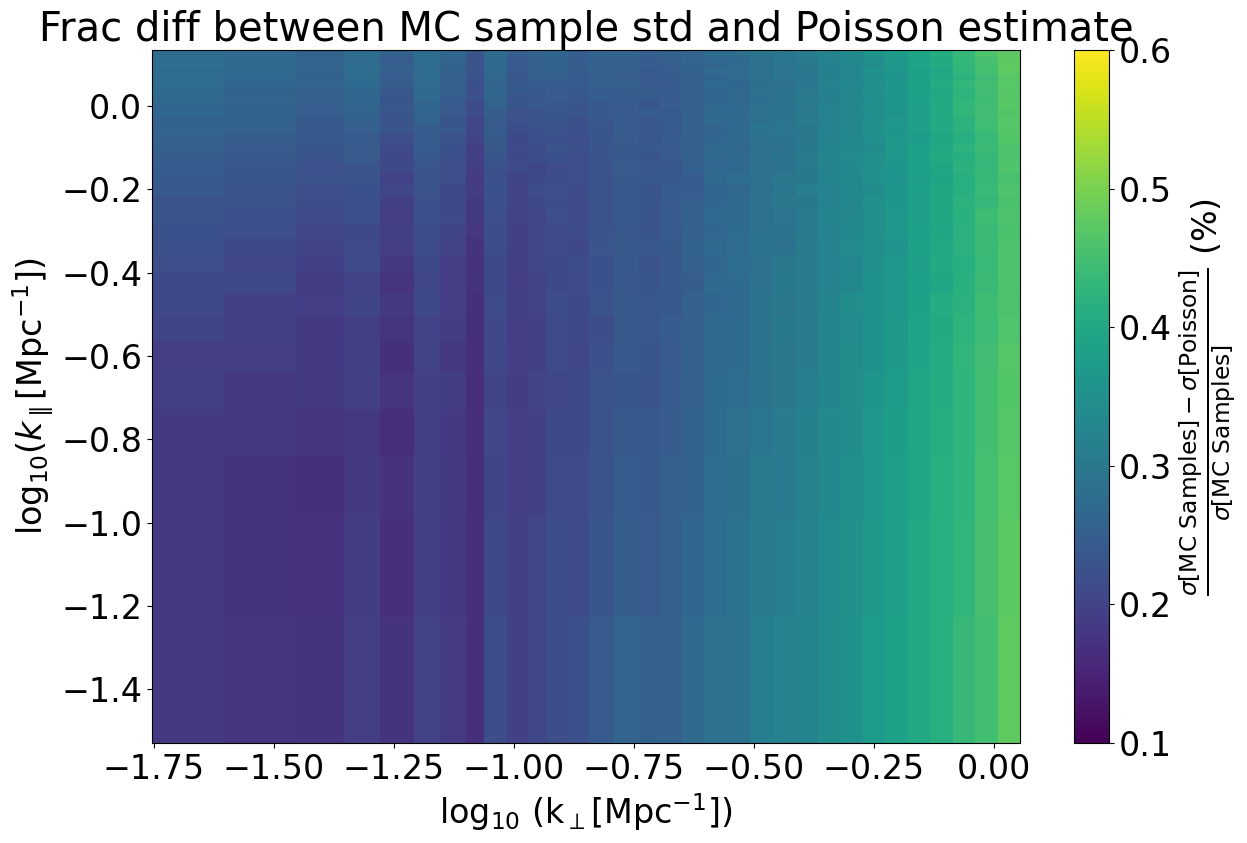

In [19]:
# Plot of fractional std diff
frac_diff_std = abs((f['poisson_stds'] - f['PS_2D_std_means']) / f['PS_2D_std_means'])

print(frac_diff_std.shape)

# avg over all thetas
frac_diff_std_avg = np.mean(frac_diff_std, axis = 0)

#we plot for z ~ 8
avg8 = frac_diff_std_avg[3,...]

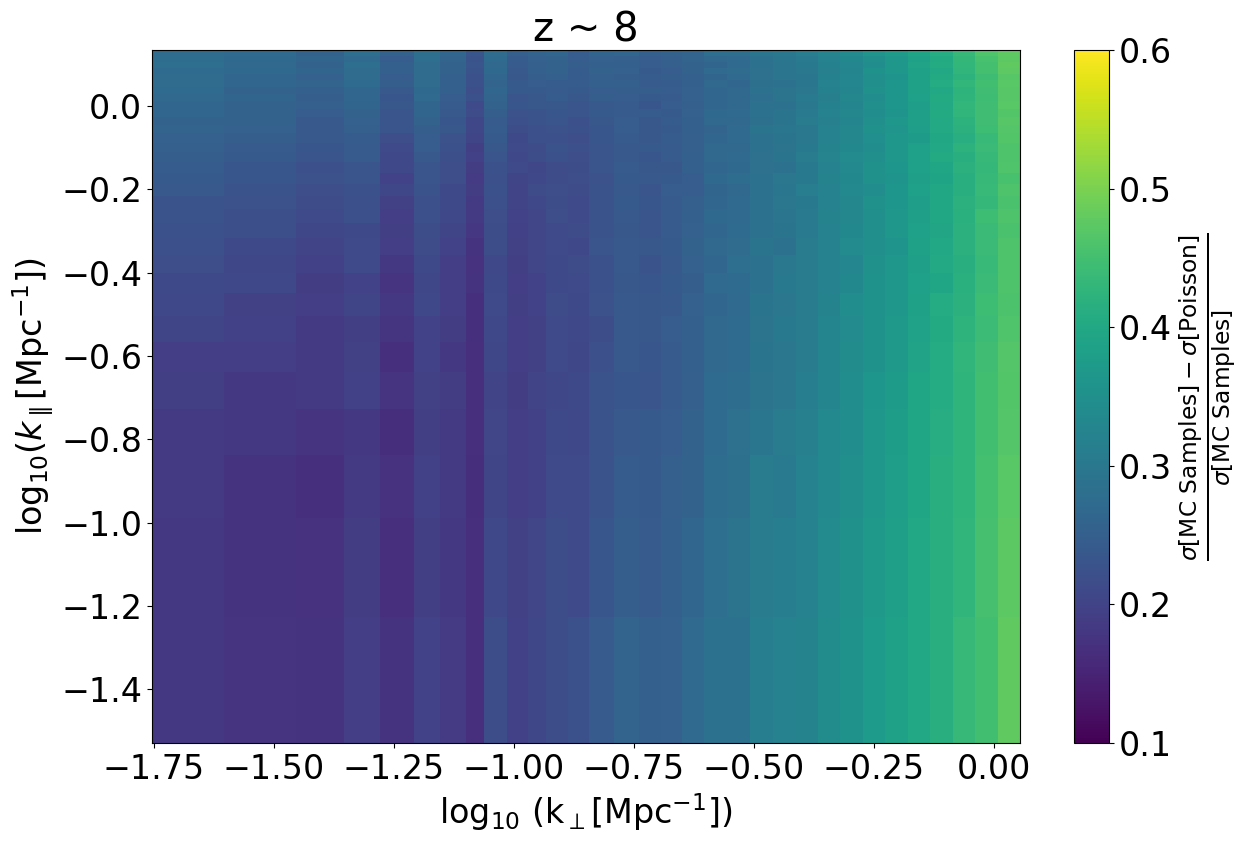

In [22]:
imshow_error_2D(avg8, xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'z ~ 8',
             vmin = 0.1, vmax = 0.6, label = r'$\frac{\sigma[{ \rm MC \ Samples}] - \sigma[{\rm Poisson}]}{\sigma[{\rm MC \ Samples}]}$', log = False)

In [10]:
sample_weights = torch.ones(shape1[0])
m = zs_final < 8
sample_weights[m] = 2.

In [11]:
#bias = 1e-8
#floor = 1e-8
noisy_norm = Normalize(input_data, log = True, axis = 0)
noisy, noisy_mean, noisy_std = noisy_norm.get_normed_data()

mean_norm = Normalize(means, log = True, axis = 0)
mean , mean_mean, mean_std = mean_norm.get_normed_data()

np.savez(model_path + name +'_norms', noisy_mean = noisy_mean, noisy_std = noisy_std, mean_mean = mean_mean, mean_std = mean_std)

In [12]:
zs_final_ch = np.zeros(mean.shape)
for i in range(mean.shape[0]):
    zs_final_ch[i,...] = zs_final[i]

In [13]:
GPU_mean_mean = torch.Tensor(mean_mean).to(DEVICE)
GPU_mean_std = torch.Tensor(mean_std).to(DEVICE)

Ngrid = torch.Tensor(Nmodes).to(DEVICE)

In [14]:
torch.cuda.memory_summary(device=DEVICE, abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   4716 KiB |   5278 KiB |   5302 KiB | 600576 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |   4716 KiB |   5278 KiB |   5302 KiB | 600576 B   |\n|---------------------------------------------------------------------------|\n| Requested memory      |   4715 KiB |   5278 KiB |   5302 KiB | 600528 B   |\n|--------------------------------------------------

In [15]:
f_train = 0.8
f_valid = 1 - f_train

print(mean.min(), mean.max())
print(std_diff.min(), std_diff.max())

outputs_1 = np.append(mean[...,np.newaxis], std_diff[...,np.newaxis], axis = -1)
#outputs_2 = np.append(noisy[...,np.newaxis], poisson_std[...,np.newaxis], axis = -1)

N_train = int(np.round(shape1[0] * f_train))
N_valid = int(np.round(shape1[0] * f_valid))

# shuffle
idx = np.arange(shape1[0])
np.random.shuffle(idx)

outputs_1 = outputs_1 # Mean + std
#outputs_2 = outputs_2[idx] # noisy + poisson
sw = sample_weights
features = noisy[:,np.newaxis,...]#np.append(noisy[:,np.newaxis,...], zs_final_ch[:,np.newaxis,...], axis = 1) # Noisy
#outputs = np.append(normed_dataset[...,1][...,np.newaxis], normed_covar[...,np.newaxis],axis = -1) # Mean and covar
#features[np.isnan(features)] = 0.
print('Training set size: ', N_train)
print('Validation set size:', N_valid)

X_train = features[idx][:N_train]
X_valid = features[idx][N_train:N_train+N_valid]

sw_train = sw[idx][:N_train]
sw_valid = sw[idx][N_train:N_train+N_valid]

Y_train = outputs_1[idx][:N_train]
Y_valid = outputs_1[idx][N_train:N_train+N_valid]

#Y_train_id = outputs_2[:N_train]
#Y_valid_id = outputs_2[N_train:N_train+N_valid]

print(X_valid.shape)

-3.881394935353991 2.047288132102479
-2.676259367632725 0.17908926764186228
Training set size:  480422
Validation set size: 120106
(120106, 1, 32, 32)


In [15]:
class PS_Dataset(Dataset):
    def __init__(self, features, labels, transform=None, target_transform=None):
        self.labels = labels
        self.features = features
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.features[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [18]:
train_DS = PS_Dataset(torch.Tensor(X_train).to(device), torch.Tensor(Y_train).to(device))
valid_DS = PS_Dataset(torch.Tensor(X_valid).to(device), torch.Tensor(Y_valid).to(device))
train_dataloader = DataLoader(train_DS, batch_size=batch_size, shuffle=True, generator = torch.Generator(device='cuda'))
valid_dataloader = DataLoader(valid_DS, batch_size=batch_size, shuffle=True, generator = torch.Generator(device='cuda'))

In [9]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU, slope: float = 1e-2):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.slope = slope
        self.act_fn = act_fn
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, stride=2),  # 16x16 => 7x7
            act_fn(c_hid),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, stride=2), # 7x7 => 3x3
            act_fn(c_hid),
            nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(c_hid),
                                    nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(c_hid),
                                    nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.Linear(c_hid * 3 * 3, latent_dim),
                                    act_fn(latent_dim),
        )
    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.kaiming_uniform_(m.weight, a = np.sqrt(5.))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
            if fan_in != 0:
                bound = 1e-3#1 / np.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
                
    def forward(self, x):
        #self.net.apply(self.init_weights)
        #self.resblock.apply(self.init_weights)
        #self.latent.apply(self.init_weights)
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 slope: float = 1e-2,
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        self.slope = slope
        self.act_fn = act_fn
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * 16 * c_hid), 
                                    act_fn(n * 16 * c_hid),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(n * 16 * c_hid),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(n * 16 * c_hid),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(n * 16 * c_hid),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(n * 16 * c_hid),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(n * c_hid),
                                    nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(n * c_hid),
                                    nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride=1),  # 4x4 => 6x6
            act_fn(n * c_hid),
            #nn.BatchNorm2d(n * c_hid),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 7x7
            act_fn(n * c_hid),
            #nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride = 1), #7x7 => 14x14
            act_fn(n * c_hid),
            #nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=3, stride = 1), #14x14 => 16x16
        )
    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.kaiming_uniform_(m.weight, a = np.sqrt(5.))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
            if fan_in != 0:
                bound = 1e-3#1 / np.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
    def forward(self, x):
        #self.linear.apply(self.init_weights)
        #self.resblock.apply(self.init_weights)
        #self.net.apply(self.init_weights)
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        #x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.LeakyReLU()(x[:,1,...])[:, np.newaxis,...]), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
        width: int = 16,
        height: int = 16,
        slope: float = 1e-2,
        act_fn: object = nn.LeakyReLU
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim, slope = slope, act_fn = act_fn)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim, slope = slope, act_fn = act_fn)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

NameError: name 'torch' is not defined

In [22]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=2, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.BatchNorm2d(c_hid),
            #nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 4x4 => 2x2
            #act_fn(),
            #nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.Linear(c_hid * 4 ** 2, latent_dim),
                                    act_fn(),
        )

    def forward(self, x):
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        outshape = 4**2
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            #nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 2x2 => 4x4
            #act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 8x8
            act_fn(),
            nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=2, stride = 2), #8x8 => 16x16
            #act_fn(),
        )
        self.floorT = torch.Tensor([0.0186]).to(DEVICE).float()
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.ReLU()(x[:,1,...]-self.floorT)[:, np.newaxis,...] +self.floorT), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [16]:
def modulelist2sequential(module:nn.ModuleList) -> nn.Sequential:
    out = nn.Sequential()
    for layer in module:
        out.append(layer)
    return out

In [17]:
class ResNet(torch.nn.Module):
    def __init__(self, module, act_fn: object = nn.LeakyReLU):
        super().__init__()
        self.module = module
        self.dropout = nn.Dropout(0.1)
        self.act = act_fn()

    def forward(self, inputs):
        return (self.module(inputs) + inputs).float()

class CNN(nn.Module):
    def __init__(self, nconvs:int, 
                 in_ch: int, out_ch: int, dropout:bool=False,
                 hid_ch:int=None, kernel_size:int = 2, f_dropout:float=0.1,
                 stride:int=1, padding:int='same', final_act:bool=False,
                 batch_norm: bool = False, 
                 act_fn: object = nn.LeakyReLU, residual:bool=False):
        super().__init__()
        self.cnn = cnn_list(nconvs=nconvs, 
                 in_ch=in_ch, out_ch=out_ch, 
                 hid_ch=hid_ch, kernel_size=kernel_size, 
                 stride=stride, padding=padding, final_act=final_act,
                 batch_norm=batch_norm, act_fn=act_fn, residual=residual)
        self.residual = residual
        
    def forward(self, x):
        y = self.cnn(x)
        return y

def cnn_list(nconvs:int, 
                 in_ch: int, out_ch: int, dropout:bool=False,
                 hid_ch:int=None, kernel_size:int = 2, f_dropout:float=0.1,
                 stride:int=1, padding:int='same', final_act:bool=False,
                 batch_norm: bool = False, act_fn: object = nn.LeakyReLU, 
                 residual:bool = False) -> nn.ModuleList:

    act = act_fn()
    if hid_ch is None:
        hid_ch = out_ch
    conv_in = nn.Sequential(nn.Conv2d(in_ch, hid_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn())
    conv_hid = nn.Sequential(nn.Conv2d(hid_ch, hid_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn())
    if batch_norm:
        conv_in.append(nn.BatchNorm2d(hid_ch))
        conv_hid.append(nn.BatchNorm2d(hid_ch))
    if dropout:
        conv_in.append(nn.Dropout(f_dropout))
        conv_hid.append(nn.Dropout(f_dropout))
    cnn = modulelist2sequential(nn.ModuleList([conv_hid for i in range(nconvs-2)]))
    if final_act:
        conv_out = nn.Sequential(nn.Conv2d(hid_ch, out_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn())
    else:
        conv_out = nn.Conv2d(hid_ch, out_ch, kernel_size = kernel_size, stride = stride, padding = padding)
    if residual:
        return ResNet(nn.Sequential(conv_in.extend(cnn.append(conv_out))))
    else:
        return conv_in.extend(cnn.append(conv_out))
        

class Autoencoder(nn.Module):
    def __init__(self, in_ch: int=2, out_ch:int=2):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        self.cnn_in = CNN(nconvs = 2, in_ch = in_ch, 
                              out_ch = 128, kernel_size = 5, padding = 'same', 
                              batch_norm = True, final_act = True, residual = False)
        self.resblock32 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 5, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.resblock32_2 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 3, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.resblock64 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.resblock128 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.cnn1 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 3, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.cnn2 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 3, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.cnn3 = CNN(nconvs = 4, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.cnn4 = CNN(nconvs = 4, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.maxpool = nn.MaxPool2d(2)
        

        ## DECODER ##
        self.resnet1 = CNN(nconvs = 2, in_ch = 128, 
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
    
        self.cnn7 = CNN(nconvs = 4, in_ch = 128, hid_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)

        self.resnet2 = CNN(nconvs = 2, in_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
        self.cnn8 = CNN(nconvs = 4, in_ch = 128, hid_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
        self.resnet3 = CNN(nconvs = 2, in_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)

        self.cnn9 = CNN(nconvs = 2, in_ch = 128, hid_ch = 128,
                           out_ch = 128, kernel_size = 6, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
        self.resnet4 = CNN(nconvs = 2, in_ch = 128,
                           out_ch = 128, kernel_size = 6, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)

        self.cnn10 = CNN(nconvs = 2, in_ch = 128, hid_ch = 16,
                           out_ch = out_ch, kernel_size = 6, padding = 'same', 
                           batch_norm = False, final_act = False, residual = False)
        self.upsample = nn.Upsample(scale_factor = 2)
    def forward(self, x):
        ## ENCODER ##
        encode1 = self.cnn_in(x)
        encode2 = self.resblock32(encode1)
        encode3 = self.maxpool(encode2)
        encode4 = self.resblock32_2(encode3)
        encode5 = self.cnn1(encode4)
        encode6 = self.cnn2(encode5)
        encode7 = self.maxpool(encode6)
        encode8 = self.resblock64(encode7)
        encode9 = self.cnn3(encode8)
        encode10 = self.maxpool(encode9) 
        
        ## Bottleneck
        encode11 = self.resblock128(encode10) 
        encode = self.cnn4(encode11)
        
        decode1 = self.resnet1(encode) + encode11
        
        ## DECODER ##
        decode2 = self.upsample(decode1)
        decode3 = self.cnn7(decode2) + encode9
        decode4 = self.resnet2(decode3) + encode8 
        decode5 = self.upsample(decode4) + encode6
        decode6 = self.cnn8(decode5) + encode5
        decode7 = self.resnet3(decode6) + encode4
        decode8 = self.upsample(decode7) + encode1
        decode9 = self.cnn9(decode8) + encode1
        decode10 = self.resnet4(decode9) + encode1
        decoded = self.cnn10(decode10)
        return decoded

In [18]:
nbatches = X_train.shape[0] // batch_size
nbatches_valid = X_valid.shape[0] // batch_size

In [19]:
def loss_mse():
    def loss(y_pred, y_true):
        mean_pred = ((torch.Tensor(y_pred[:,0,...] * GPU_mean_std) + GPU_mean_mean))
        mean_true = ((torch.Tensor(y_true[...,0] * GPU_mean_std) + GPU_mean_mean))
        diff_pred = (torch.Tensor(y_pred[:,1,...]))
        diff_true = (torch.Tensor(y_true[...,1]))
        mse_ps = nn.MSELoss()(mean_pred, mean_true)
        mse_var = nn.MSELoss()(diff_pred, diff_true)
        return mse_ps + mse_var
    return loss

def loss_KL(w): # KL
    def loss(y_pred, y_true):
        #print('WTF', torch.Tensor(y_pred[:,1,...]))
        mean_pred = 10**((torch.Tensor(y_pred[:,0,...] * GPU_mean_std) + GPU_mean_mean))
        mean_true = 10**((torch.Tensor(y_true[...,0] * GPU_mean_std) + GPU_mean_mean))
        diff_pred = (torch.Tensor(y_pred[:,1,...])) 
        diff_true = (torch.Tensor(y_true[...,1])) 
        std_pred = 10**(torch.log10(mean_pred / torch.sqrt(Ngrid)) - diff_pred)
        std_true = 10**(torch.log10(mean_true / torch.sqrt(Ngrid)) - diff_true)

        var_pred = std_pred ** 2 #+ 1e-3
        var_true = std_true ** 2 #+ 1e-3 
        m1 = var_pred < 1e-2
        #var_true[m1] = 1e-2
        var_pred[m1] = 1e-2
        m2 = var_true < 1e-2
        var_true[m2] = 1e-2
        diff = mean_true - mean_pred
        D_KL = 1./2. * torch.nansum((diff ** 2 / var_true + var_pred / var_true + torch.log(var_true) - torch.log(var_pred)), [1,2])
        #print(torch.min(var_pred), torch.max(var_pred), torch.max(y_pred[:,0,...]))
        #print(torch.min(var_true), torch.max(var_true))
        #print(torch.nanmean(var_pred, [1,2]), torch.nanmean(var_true, [1,2]), torch.nanmean(1 / var_true, [1,2]))
        #print(torch.nanmean(diff ** 2, [1,2]), torch.nanmean(diff ** 2 / var_pred, [1,2]), torch.nanmean(var_pred / var_true, [1,2]), torch.nanmean(torch.log(var_true) - torch.log(var_pred), [1,2]))
        #print(D_KL)
        #print('AAAA', torch.mean(D_KL))
        if torch.isnan(torch.mean(D_KL)):
            m = ~torch.isnan(torch.log(std_pred))
            print('PREDDDD', mean_pred)
            print('TRUEEE', mean_true)
            print('VPPPPP', 1/var_pred)
            print('VT/VPPPP', var_true / var_pred)
            print('VT MIIIN', var_true.min())
            print('VP MIIIN', var_pred.min())
            return torch.nanmean(D_KL[m]) * 2.
        else:
            return torch.mean(D_KL)
    return loss
def loss_test(w):
    def loss(y_pred, y_true):
        mean_pred = 10**((torch.Tensor(y_pred[:,0,...] * GPU_mean_std) + GPU_mean_mean))
        mean_true = 10**((torch.Tensor(y_true[...,0] * GPU_mean_std) + GPU_mean_mean))
        diff_pred = (torch.Tensor(y_pred[:,1,...])) 
        diff_true = (torch.Tensor(y_true[...,1])) 
        std_pred = 10**(torch.log10(mean_pred / torch.sqrt(Ngrid)) - diff_pred)
        std_true = 10**(torch.log10(mean_true / torch.sqrt(Ngrid)) - diff_true)

        var_pred = std_pred ** 2 #+ 1e-3
        var_true = std_true ** 2 #+ 1e-3 
        m1 = var_pred < 1e-2
        #var_true[m1] = 1e-2
        var_pred[m1] = 1e-2
        m2 = var_true < 1e-2
        var_true[m2] = 1e-2
        diff = mean_true - mean_pred
        D_KL = 1./2. * torch.nansum((diff ** 2 / var_true + var_pred / var_true + torch.log(var_true) - torch.log(var_pred)), [1,2])
        kl = torch.mean(D_KL)
        if torch.isnan(kl):
            kl = 0
            
        mean_pred = ((torch.Tensor(y_pred[:,0,...] * mean_std) + mean_mean))
        mean_true = ((torch.Tensor(y_true[...,0] * mean_std) + mean_mean))
        diff_pred = (torch.Tensor(y_pred[:,1,...]))
        diff_true = (torch.Tensor(y_true[...,1]))
        mse_ps = nn.MSELoss()(mean_pred, mean_true)
        mse_var = nn.MSELoss()(diff_pred, diff_true)
        if mse_ps+mse_var > 1e-3:
            wkl = 0
        else:
            wkl=1e-4
        return mse_ps + mse_var + kl*wkl
    return loss

def loss_test2(w):
    def loss(y_pred, y_true):
        mean_pred = 10**((torch.Tensor(y_pred[:,0,...] * mean_std) + mean_mean))
        mean_true = 10**((torch.Tensor(y_true[...,0] * mean_std) + mean_mean))
        diff_pred = (torch.Tensor(y_pred[:,1,...])) 
        diff_true = (torch.Tensor(y_true[...,1])) 
        std_pred = 10**(torch.log10(mean_pred / torch.sqrt(Ngrid)) - diff_pred)
        std_true = 10**(torch.log10(mean_true / torch.sqrt(Ngrid)) - diff_true)

        var_pred = std_pred ** 2 #+ 1e-3
        var_true = std_true ** 2 #+ 1e-3 
        m1 = var_pred < 1e-2
        #var_true[m1] = 1e-2
        var_pred[m1] = 1e-2
        m2 = var_true < 1e-2
        var_true[m2] = 1e-2
        diff = mean_true - mean_pred
        D_KL = 1./2. * torch.nansum((diff ** 2 / var_true + var_pred / var_true + torch.log(var_true) - torch.log(var_pred)), [1,2])
        kl = torch.mean(D_KL)
        if torch.isnan(kl):
            kl = 0
            
        mean_pred = ((torch.Tensor(y_pred[:,0,...] * mean_std) + mean_mean))
        mean_true = ((torch.Tensor(y_true[...,0] * mean_std) + mean_mean))
        diff_pred = (torch.Tensor(y_pred[:,1,...]))
        diff_true = (torch.Tensor(y_true[...,1]))
        mse_ps = nn.MSELoss()(mean_pred, mean_true)
        mse_var = nn.MSELoss()(diff_pred, diff_true)
        if kl > 900:
            wmse = 0
        else:
            wmse=1000.
        return (mse_ps + mse_var)*wmse + kl
    return loss

def get_FE(y_pred, y_true):
    mean_pred = 10**((torch.Tensor(y_pred[:,0,...] * GPU_mean_std) + GPU_mean_mean))
    mean_true = 10**((torch.Tensor(y_true[...,0] * GPU_mean_std) + GPU_mean_mean))
    diff_pred = (torch.Tensor(y_pred[:,1,...]))
    diff_true = (torch.Tensor(y_true[...,1]))
    std_pred = 10**(torch.log10(mean_pred / torch.sqrt(Ngrid)) - diff_pred)
    std_true = 10**(torch.log10(mean_true / torch.sqrt(Ngrid)) - diff_true)
    m1 = std_pred < 1e-1
    std_pred[m1] = 1e-1
    m2 = std_true < 1e-1
    std_true[m2] = 1e-1
    mu_fe = abs((mean_pred - mean_true)/mean_true) * 100.
    std_fe = abs((std_pred - std_true)/std_true) * 100.
    
    return torch.nanmean(mu_fe), torch.nanmean(std_fe)

In [42]:
print(X_train[0,0,...])

[[ 0.35982213  0.49483158  0.30754926 ...  0.32341346  0.40144668
   0.41777286]
 [ 0.30942932  0.35750151  0.31490465 ...  0.35106129  0.04587131
   0.2028859 ]
 [ 0.40764915  0.39970716  0.10872411 ...  0.04301072 -0.171674
  -0.11436501]
 ...
 [ 0.03018119  0.05339453  0.0510931  ...  0.17004887  0.17775401
   0.15475407]
 [ 0.03882992  0.06359934  0.06512474 ...  0.17431751  0.1722897
   0.1367403 ]
 [ 0.07861471  0.06177357  0.06697215 ...  0.15027121  0.13572454
   0.12314149]]


In [45]:
class Residual_Denoiser(nn.Module):
    def __init__(
        self,
        in_channel_num: int,
        out_channel_num: int,
        act_fn: object = nn.LeakyReLU
    ):
        super().__init__()
        self.act_fn = act_fn
        self.resblock532 = ResNet(nn.Sequential(nn.Conv2d(32, 32, kernel_size=5, padding = 'same'),
                                act_fn(),
                                nn.BatchNorm2d(32),
                                nn.Conv2d(32, 32, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.resblock32 = ResNet(nn.Sequential(nn.Conv2d(32, 32, kernel_size=3, padding = 'same'),
                                act_fn(),
                                nn.BatchNorm2d(32),
                                nn.Conv2d(32, 32, kernel_size=3, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.resblock64 = ResNet(nn.Sequential(nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                nn.BatchNorm2d(64),
                                nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.resblock128 = ResNet(nn.Sequential(nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                nn.BatchNorm2d(128),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.resblock5512 = ResNet(nn.Sequential(nn.Conv2d(256, 512, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(512, 512, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        
        self.resblock5in = ResNet(nn.Sequential(nn.Conv2d(in_channel_num, 32, kernel_size=5, padding = 'same'),
                                act_fn(),
                                nn.BatchNorm2d(32),
                                nn.Conv2d(32, 32, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.resblock5out = ResNet(nn.Sequential(nn.Conv2d(256, 2, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(2, 2, kernel_size=5, padding = 'same'),
                                ))
        self.maxpool5 = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor = 2)
        self.cnn1 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=3, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.cnn2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.cnn3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.cnn4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.cnn5 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(256, 256, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.cnn6 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(256, 256, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.resnet1 = ResNet(nn.Sequential(nn.Conv2d(256, 256, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(256, 256, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.cnn7 = nn.Sequential(nn.Conv2d(256, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.resnet2 = ResNet(nn.Sequential(nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.cnn8 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.resnet3 = ResNet(nn.Sequential(nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.cnn9 = nn.Sequential(nn.Conv2d(64, 32, kernel_size=6, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(32, 32, kernel_size=6, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.resnet4 = ResNet(nn.Sequential(nn.Conv2d(32, 32, kernel_size=6, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(32, 32, kernel_size=6, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.cnn10 = nn.Sequential(nn.Conv2d(32, 16, kernel_size=6, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(16, out_channel_num, kernel_size=6, padding = 'same'),
                                )
    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        act_fn = self.act_fn
        y = self.resblock5in(x)
        y = self.resblock532(y)
        y = self.maxpool5(y)
        y = self.resblock32(y)
        y = self.cnn1(y)
        y = self.cnn2(y)
        y = self.maxpool5(y)
        y = self.resblock64(y)
        y = self.cnn3(y)
        y = self.cnn4(y)
        y = self.maxpool5(y)
        y = self.resblock128(y)
        y = self.cnn5(y)
        y = self.cnn6(y)
        ## End Encoder
        y = self.resnet1(y)
        y = self.upsample(y)
        y = self.cnn7(y)
        y = self.resnet2(y)
        y = self.upsample(y)
        y = self.cnn8(y)
        y = self.resnet3(y)
        y = self.upsample(y)
        
        y = self.cnn9(y)
        y = self.resnet4(y)
        y = self.cnn10(y)
        return y

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [405]:
epochs = 1000
epoch = 0
scheduler1 = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.9)
model.train()
all_losses = []
epoch_losses = []

all_vlosses = []
epoch_vlosses = []
epoch_lr = []

all_percents = []
while epoch < epochs:
    model.float()
    tmp = []
    for batch_num in range(nbatches):
        optimizer.zero_grad()
        x = torch.Tensor(X_train[batch_num*batch_size:(batch_num+1)*batch_size][:,...])
        y = torch.Tensor(Y_train_id[batch_num*batch_size:(batch_num+1)*batch_size,...][:,...])
        #var = torch.Tensor(Y_train[batch_num*batch_size:(batch_num+1)*batch_size][:, np.newaxis,...,1])
        #full_x = torch.cat((y,var), axis = 1)
        x = x.to(DEVICE).float()
        y = y.to(DEVICE).float()
        #full_x = full_x.to(DEVICE).float()
        output = model(x[:,np.newaxis,...])
        loss = criterion(output, y)
        loss.backward()
        
        tmp.append(loss.item())
        all_losses.append(loss.item())
        model.float()
        optimizer.step()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        vtmp = []
        for batch_num_valid in range(nbatches_valid):
            x = torch.Tensor(X_valid[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size][:,...])
            y = torch.Tensor(Y_valid_id[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size,...][:,...])
            x = x.to(DEVICE).float()
            y = y.to(DEVICE).float()

            x = x.to(DEVICE).float()
            output = model(x[:,np.newaxis,...])#model(y[:,np.newaxis,...,0])
            vloss = criterion(output, y)
            all_vlosses.append(vloss)
            vtmp.append(vloss)
        epoch_vlosses.append(torch.median(torch.Tensor(vtmp)).detach().cpu().numpy())
        #print(output.min(), ' vs ', x.min(), output.max(), ' vs ', x.max())
    
    epoch_losses.append(np.median(tmp))
    epoch_lr.append(optimizer.param_groups[0]["lr"])
    if epoch == 0:
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        print(mloss, vloss)
        print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E}')
    if epoch > 0 and optimizer.param_groups[0]["lr"] >= 1e-12:
        this_loss = epoch_vlosses[-1]
        prev_loss = np.min(epoch_vlosses[:-1])
        percent = (prev_loss - this_loss)/this_loss * 100.
        all_percents.append(percent)
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E} | VLoss FE {percent/100.:.2%} ')
        if percent < 1e-3 and percent > 0:
            scheduler2.step()
            scheduler1.step()
        elif percent < 0.5 and percent > 0:
            scheduler2.step()
        elif percent < 0:
            # final plateau check
            this_loss = epoch_vlosses[-1]
            prev_loss = np.array(epoch_vlosses[-10:])
            plateau_percent = np.mean(abs((this_loss - prev_loss)/this_loss) * 100.)
            if epoch > 10 and plateau_percent < 1e-3:
                # Stop if if plateaued for 10 epochs
                epoch = epochs
            elif epoch > 4 and np.any(np.array(all_percents[-3:-1]) < 0):
                scheduler2.step()
                scheduler1.step()
            else:
                scheduler2.step()
                scheduler1.step()
        if epoch < 5:
            scheduler1.step()
    if optimizer.param_groups[0]["lr"] < 1e-12:
        epoch = epochs
    epoch += 1
    if (epoch > 5 and this_loss <= np.min(epoch_vlosses)) or epoch == epochs - 1 or loss < 1:
        if loss < 1:
            torch.save(model.state_dict(), model_path+name+'_id0')
        else:
            torch.save(model.state_dict(), model_path+name+'_id')

tensor(921.8047) tensor(845.3148)
Epoch 0 | Loss 9.2180E+02 | Val Loss 8.4531E+02 | lr 1.0000E-03
Epoch 1 | Loss 8.1352E+02 | Val Loss 7.8318E+02 | lr 1.0000E-03 | VLoss FE 7.93% 
Epoch 2 | Loss 7.5853E+02 | Val Loss 7.3183E+02 | lr 9.0000E-04 | VLoss FE 7.02% 
Epoch 3 | Loss 7.1704E+02 | Val Loss 6.9832E+02 | lr 8.1000E-04 | VLoss FE 4.80% 
Epoch 4 | Loss 6.8961E+02 | Val Loss 6.7445E+02 | lr 7.2900E-04 | VLoss FE 3.54% 
Epoch 5 | Loss 6.6409E+02 | Val Loss 6.4300E+02 | lr 6.5610E-04 | VLoss FE 4.89% 
Epoch 6 | Loss 6.1375E+02 | Val Loss 5.6494E+02 | lr 6.5610E-04 | VLoss FE 13.82% 
Epoch 7 | Loss 5.3703E+02 | Val Loss 5.0651E+02 | lr 6.5610E-04 | VLoss FE 11.54% 
Epoch 8 | Loss 5.1123E+02 | Val Loss 4.6198E+02 | lr 6.5610E-04 | VLoss FE 9.64% 
Epoch 9 | Loss 5.0497E+02 | Val Loss 4.5170E+02 | lr 6.5610E-04 | VLoss FE 2.27% 
Epoch 10 | Loss 5.0826E+02 | Val Loss 6.0568E+02 | lr 6.5610E-04 | VLoss FE -25.42% 
Epoch 11 | Loss 5.5624E+02 | Val Loss 5.1360E+02 | lr 5.3144E-04 | VLoss FE -

KeyboardInterrupt: 

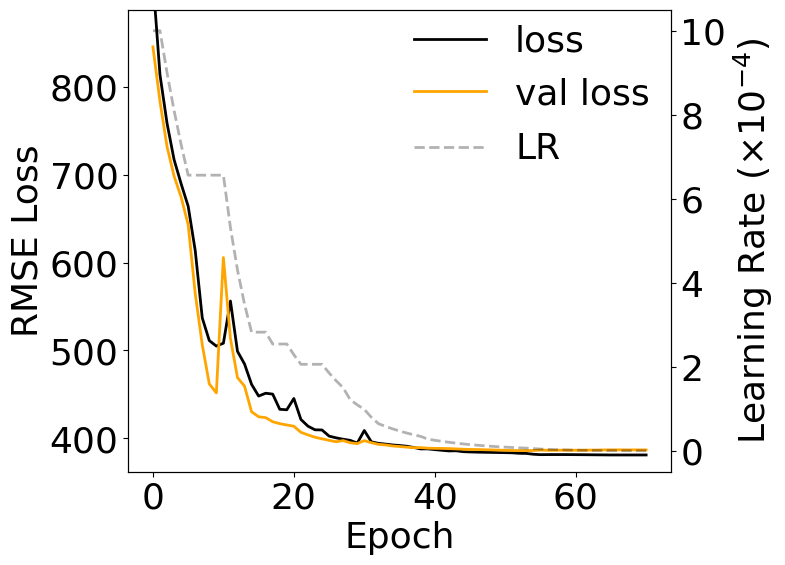

In [406]:
history = {'loss': epoch_losses, 'val_loss': epoch_vlosses, 'lr': epoch_lr}
np.savez(model_path+name+'_history_id', **history)

np.savez(model_path+name+'_cst', mean_PS_mean = mean_mean.cpu().numpy(), mean_PS_std = mean_std.cpu().numpy(), 
         noisy_PS_mean = noisy_mean.cpu().numpy(), noisy_PS_std = noisy_std.cpu().numpy(),
         std_mean = std_mean.cpu().numpy(), std_std = std_std.cpu().numpy())
plot_hist(history, np.floor(min(epoch_losses)*10000.)/10000.*0.95, np.ceil(max(epoch_vlosses)*1000.)/1000.*1.05)

In [20]:
w = np.ones((len(kperp), len(kpar)))
w[0,:5] = 2.
w[1,:4] = 2.
w[2,:4] = 2.
w[3,:4] = 2.
w[4,:3] = 2.
w[5,:2] = 2.
w[:9,0] = 2.

w[-6:,0] = 2.
w[-5:,1] = 2.
w[-3:,2] = 2.
w[-2:,3] = 2.

w[0,-20:] = 1.3
w[1,-15:] = 1.3
w[2,-8:] = 1.3
w[3,-5:] = 1.3
w[4,-3:] = 1.3

w[-1,-10:] = 1.3
w[-2,-3:] = 1.3

w = np.ones((len(kperp), len(kpar)))
w[:,:10] = 2.
w = torch.Tensor(w).to(DEVICE, dtype=torch.float64)

In [52]:
del model
torch.cuda.empty_cache() 
gc.collect()

0

In [21]:
torch.cuda.memory_summary(device=device, abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  14108 KiB |  18792 KiB |  24078 KiB |   9970 KiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  14108 KiB |  18792 KiB |  24078 KiB |   9970 KiB |\n|---------------------------------------------------------------------------|\n| Requested memory      |  14106 KiB |  18790 KiB |  24076 KiB |   9969 KiB |\n|--------------------------------------------------

In [23]:
# Setting the seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
model = Autoencoder(in_ch=1)
#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = loss_mse()
metric = loss_KL(w)

In [24]:
torch.cuda.memory_summary(device=device, abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  62781 KiB |  66804 KiB |  95947 KiB |  33165 KiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  62781 KiB |  66804 KiB |  95947 KiB |  33165 KiB |\n|---------------------------------------------------------------------------|\n| Requested memory      |  60981 KiB |  65004 KiB |  92686 KiB |  31705 KiB |\n|--------------------------------------------------

In [ ]:
epochs = 1000
epoch = 0
scheduler1 = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.1)
scheduler3 = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.2)

all_losses = []
epoch_losses = []

all_vlosses = []
epoch_vlosses = []
epoch_lr = []

all_percents = []
all_mu_FEs = []
all_std_FEs = []

idx = np.arange(N_train)
optimize = 'vloss'
t0 = time()
while epoch < epochs:
    tmp = []
    mufetmp = []
    stdfetmp = []
    np.random.shuffle(idx)
    X_shuffled = X_train[idx]
    Y_shuffled = Y_train[idx]
    model.train()
    model.float()
    for batch_num in range(nbatches):
        t2 = time()
        optimizer.zero_grad()
        x = torch.Tensor(X_shuffled[batch_num*batch_size:(batch_num+1)*batch_size])
        y = torch.Tensor(Y_shuffled[batch_num*batch_size:(batch_num+1)*batch_size,...])
        
        x = x.to(DEVICE).float()
        y = y.to(DEVICE).float()

        #full_x = full_x.to(DEVICE).float()
        
        output = model(x)

        #print('Min: T, P ', torch.min(y[...,0]),torch.min(output[:,0,...]))
        #print('Max: T, P ', torch.max(y[...,0]),torch.max(output[:,0,...]))
        loss = criterion(output, y)

        #print('Loss: ', loss)
        loss.backward()
        mu, std = get_FE(output,y)

        mufetmp.append(mu.detach().cpu().numpy())
        stdfetmp.append(std.detach().cpu().numpy())
        tmp.append(loss.item())
        all_losses.append(loss.item())
        
        optimizer.step()

        x.cpu()
        y.cpu()
        loss.cpu()
        mu.cpu()
        std.cpu()
        output.cpu()
        del loss, x, y, output, mu, std
    torch.cuda.empty_cache() 
    gc.collect()
        
    #print('Min: T, P ', torch.min(y[...,0]),torch.min(output[:,0,...]))
    #print('Max: T, P ', torch.max(y[...,0]),torch.max(output[:,0,...]))
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        vtmp = []
        vmufetmp = []
        vstdfetmp = []
        vkl = []
        vmse = []
        model.eval()
        for batch_num_valid in range(nbatches_valid):
            x = torch.Tensor(X_valid[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size])
            y = torch.Tensor(Y_valid[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size,...])
            x = x.to(DEVICE).float()
            y = y.to(DEVICE).float()
            
            output = model(x)
            vloss = criterion(output, y)
            all_vlosses.append(vloss)
            vtmp.append(vloss)
            mu, std = get_FE(output,y)
            vmufetmp.append(mu.detach().cpu().numpy())
            vstdfetmp.append(std.detach().cpu().numpy())
            vkl.append(loss_KL(w)(output,y).detach().cpu().numpy())
            vmse.append(loss_mse()(output,y).detach().cpu().numpy())
            x.cpu()
            y.cpu()
            vloss.cpu()
            mu.cpu()
            std.cpu()
            del vloss, x, y, output, std, mu
        torch.cuda.empty_cache() 
        gc.collect()
        epoch_vlosses.append(torch.median(torch.Tensor(vtmp)).detach().cpu().numpy())
        #print(output.min(), ' vs ', x.min(), output.max(), ' vs ', x.max())
    
    epoch_losses.append(np.median(tmp))
    epoch_lr.append(optimizer.param_groups[0]["lr"])
    all_mu_FEs.append(np.mean(vmufetmp))
    all_std_FEs.append(np.mean(vstdfetmp))
    vmetric = torch.median(torch.Tensor(np.array(vkl)))
    vmetric1 = torch.median(torch.Tensor(np.array(vmse)))
    if epoch == 0:
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E} | Valid Mean FE {all_mu_FEs[-1]/100.:.2%} | Valid STD FE {all_std_FEs[-1]/100.:.2%} | Valid KL {vmetric:.4E} | Valid MSE {vmetric1:.4E}')
    if epoch > 0 and optimizer.param_groups[0]["lr"] >= 1e-12:
        if optimize.lower() == 'loss':
            this_loss = epoch_losses[-1]
            prev_loss = np.min(epoch_losses[:-1])
            percent = (prev_loss - this_loss)/this_loss * 100.
        else:
            this_loss = epoch_vlosses[-1]
            prev_loss = np.min(epoch_vlosses[:-1])
            percent = (prev_loss - this_loss)/this_loss * 100.
        all_percents.append(percent)
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        if optimize.lower() == 'loss':
            print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E} | Loss FE {percent/100.:.2%} | Valid Mean FE {all_mu_FEs[-1]/100.:.2%} | Valid STD FE {all_std_FEs[-1]/100.:.2%} | Valid KL {vmetric:.4E} | Valid MSE {vmetric1:.4E}')
        else:
            print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E} | VLoss FE {percent/100.:.2%} | Valid Mean FE {all_mu_FEs[-1]/100.:.2%} | Valid STD FE {all_std_FEs[-1]/100.:.2%} | Valid KL {vmetric:.4E} | Valid MSE {vmetric1:.4E}')
        if percent < 1e-1 and percent > 0:
            scheduler2.step()
        elif percent < 0:
            # final plateau check
            this_loss = epoch_vlosses[-1]
            prev_loss = np.array(epoch_vlosses[-10:])
            plateau_percent = np.mean(abs((this_loss - prev_loss)/this_loss) * 100.)
            if epoch > 10 and plateau_percent < 1e-3:
                # Stop if if plateaued for 10 epochs
                epoch = epochs
            elif epoch > 4 and (np.any(np.array(all_percents[-3:-1]) < 0) or percent < -1):
                scheduler2.step()
                scheduler1.step()
            else:
                scheduler1.step()
        #elif percent > 100:
        #        scheduler2.step()
        #        scheduler1.step()
    if optimizer.param_groups[0]["lr"] < 1e-10:
        epoch = epochs
    epoch += 1
    if (epoch > 5 and this_loss <= np.min(epoch_vlosses)):
        torch.save(model.state_dict(), model_path+name+'_mse')

/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/Convolution.cpp:1003.)
  return func(*args, **kwargs)


Epoch 0 | Loss 9.0362E-02 | Val Loss 4.9900E-02 | lr 1.0000E-04 | Valid Mean FE 20.69% | Valid STD FE 20.68% | Valid KL 1.8601E+03 | Valid MSE 4.9900E-02


In [ ]:
history = {'loss': epoch_losses, 'val_loss': epoch_vlosses, 'lr': epoch_lr}

In [ ]:
np.savez(model_path+name+'_history_mse', **history)

In [ ]:
#history = dict(np.load(model_path+name+'_history_mse.npz'))

In [13]:
#epoch_losses = history['loss']

In [ ]:
plot_hist(history, np.floor(min(epoch_losses)*10000.)/10000.*0.95, np.ceil(max(epoch_losses)*1000.)/1000.*1.05)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
# Setting the seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
model = Autoencoder(in_ch=1)
#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6, weight_decay=1e-5)
criterion = loss_KL(w)
metric = loss_mse()

In [ ]:
model.load_state_dict(torch.load(model_path+'Dec24_mse'))

In [ ]:
epochs = 1000
epoch = 0
scheduler1 = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.1)
scheduler3 = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.2)
all_losses = []
epoch_losses = []

all_vlosses = []
epoch_vlosses = []
epoch_lr = []

all_percents = []
all_mu_FEs = []
all_std_FEs = []
idx = np.arange(N_train)
optimize = 'vloss'
while epoch < epochs:
    tmp = []
    mufetmp = []
    stdfetmp = []
    model.float()
    np.random.shuffle(idx)
    X_shuffled = X_train[idx]
    Y_shuffled = Y_train[idx]
    model.train()
    model.float()
    for batch_num in range(nbatches):
        optimizer.zero_grad()
        x = torch.Tensor(X_shuffled[batch_num*batch_size:(batch_num+1)*batch_size])
        y = torch.Tensor(Y_shuffled[batch_num*batch_size:(batch_num+1)*batch_size,...])
        
        x = x.to(DEVICE).float()
        y = y.to(DEVICE).float()

        output = model(x)
        #print('Min: T, P ', torch.min(y[...,0]),torch.min(output[:,0,...]))
        #print('Max: T, P ', torch.max(y[...,0]),torch.max(output[:,0,...]))
        loss = criterion(output, y)
        if loss > 1e10:
            print(loss, batch_num)
            shitty_input = x
            shitty_output = y
        #print('Loss: ', loss)
        loss.backward()
        mu, std = get_FE(output,y)
        mufetmp.append(mu.detach().cpu().numpy())
        stdfetmp.append(std.detach().cpu().numpy())
        tmp.append(loss.item())
        all_losses.append(loss.item())
        optimizer.step()
        del loss, x, y, output, std, mu
    torch.cuda.empty_cache() 
    gc.collect()
        
    #print('Min: T, P ', torch.min(y[...,0]),torch.min(output[:,0,...]))
    #print('Max: T, P ', torch.max(y[...,0]),torch.max(output[:,0,...]))
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        vtmp = []
        vmufetmp = []
        vstdfetmp = []
        vkl = []
        vmse = []
        model.eval()
        for batch_num_valid in range(nbatches_valid):
            x = torch.Tensor(X_valid[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size])
            y = torch.Tensor(Y_valid[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size,...])
            x = x.to(DEVICE).float()
            y = y.to(DEVICE).float()

            output = model(x)
            vloss = criterion(output, y)
            all_vlosses.append(vloss)
            vtmp.append(vloss)
            mu, std = get_FE(output,y)
            vmufetmp.append(mu.detach().cpu().numpy())
            vstdfetmp.append(std.detach().cpu().numpy())
            vkl.append(loss_KL(w)(output,y).detach().cpu().numpy())
            vmse.append(loss_mse()(output,y).detach().cpu().numpy())
            del vloss, x, y, output, mu, std
        torch.cuda.empty_cache() 
        gc.collect()
        epoch_vlosses.append(torch.median(torch.Tensor(vtmp)).detach().cpu().numpy())
        #print(output.min(), ' vs ', x.min(), output.max(), ' vs ', x.max())
    
    epoch_losses.append(np.median(tmp))
    epoch_lr.append(optimizer.param_groups[0]["lr"])
    all_mu_FEs.append(np.mean(vmufetmp))
    all_std_FEs.append(np.mean(vstdfetmp))
    vmetric = torch.median(torch.Tensor(np.array(vkl)))
    vmetric1 = torch.median(torch.Tensor(np.array(vmse)))
    if epoch == 0:
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E} | Valid Mean FE {all_mu_FEs[-1]/100.:.2%} | Valid STD FE {all_std_FEs[-1]/100.:.2%} | Valid KL {vmetric:.4E} | Valid MSE {vmetric1:.4E}')
    if epoch > 0 and optimizer.param_groups[0]["lr"] >= 1e-12:
        if optimize.lower() == 'loss':
            this_loss = epoch_losses[-1]
            prev_loss = np.min(epoch_losses[:-1])
            percent = (prev_loss - this_loss)/this_loss * 100.
        else:
            this_loss = epoch_vlosses[-1]
            prev_loss = np.min(epoch_vlosses[:-1])
            percent = (prev_loss - this_loss)/this_loss * 100.
        all_percents.append(percent)
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        if optimize.lower() == 'loss':
            print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E} | Loss FE {percent/100.:.2%} | Valid Mean FE {all_mu_FEs[-1]/100.:.2%} | Valid STD FE {all_std_FEs[-1]/100.:.2%} | Valid KL {vmetric:.4E} | Valid MSE {vmetric1:.4E}')
        else:
            print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E} | VLoss FE {percent/100.:.2%} | Valid Mean FE {all_mu_FEs[-1]/100.:.2%} | Valid STD FE {all_std_FEs[-1]/100.:.2%} | Valid KL {vmetric:.4E} | Valid MSE {vmetric1:.4E}')
        if percent < 1e-1 and percent > 0:
            scheduler2.step()
        elif percent < 0:
            # final plateau check
            this_loss = epoch_vlosses[-1]
            prev_loss = np.array(epoch_vlosses[-10:])
            plateau_percent = np.mean(abs((this_loss - prev_loss)/this_loss) * 100.)
            if epoch > 10 and plateau_percent < 1e-3:
                # Stop if if plateaued for 10 epochs
                epoch = epochs
            elif epoch > 4 and (np.any(np.array(all_percents[-3:-1]) < 0) or percent < -1):
                scheduler2.step()
                scheduler1.step()
            else:
                scheduler1.step()
        #elif percent > 100:
        #        scheduler2.step()
        #        scheduler1.step()
    if optimizer.param_groups[0]["lr"] < 1e-10:
        epoch = epochs
    epoch += 1
    if (epoch > 5 and this_loss <= np.min(epoch_vlosses)):
        torch.save(model.state_dict(), model_path+name+'_KL2')

In [ ]:
history = {'loss': epoch_losses, 'val_loss': epoch_vlosses, 'lr': epoch_lr}

In [ ]:
np.savez(model_path+name+'_w_KL', w.cpu().numpy())
np.savez(model_path+name+'_history_KL', **history)

In [ ]:
all_mu_FEs

In [88]:
all_mu_FEs

[11.559527575242088,
 11.28629803060929,
 10.981353516456005,
 10.805264440764347,
 10.789820989027449,
 10.55187059157244,
 10.39018598542917,
 10.327388105732483,
 10.275405889128434,
 10.187499465466574,
 10.136330989092615,
 10.061427935624199,
 10.062480601958757,
 10.060194207320896,
 10.059732356989546,
 10.06025562065476,
 10.060360641266948,
 10.06036285290846,
 10.060362845466903]

In [38]:
all_std_FEs

[12.74559214120952,
 12.374150852778891,
 11.935667660485686,
 11.820048701511805,
 11.711663983068911,
 11.645439499110687,
 11.646208960178509,
 11.597409859688229,
 11.596427669646772,
 11.573853146469366,
 11.573037904432145,
 11.571231125614768,
 11.570755072410249,
 11.570627243325388]

In [89]:
all_std_FEs

[14.663530500865372,
 14.142508395818801,
 13.299838097470142,
 12.84481937846395,
 12.691273112667016,
 12.525750811289146,
 12.422427687747636,
 12.40503299298057,
 12.36513090770229,
 12.342440188261133,
 12.297509546127863,
 12.283902002035111,
 12.259009691064199,
 12.260986721580204,
 12.256795745753463,
 12.256478910362258,
 12.256386706421985,
 12.256385745201671,
 12.256385672024502]